#  Customer Segmentation - Clustering

In [1]:
#İhtiyacımız olan kütüphaneleri içe aktarıyoruz

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",200)
import sqlite3
from sqlite3 import Error
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
#Verimizi okouyup, inceliyoruz

In [4]:
df=pd.read_csv("PBL5recommendationdata.csv",encoding="latin-1")

In [5]:
df.sample(3)

,Customers.id,Customers.fname,Customers.lname,Customers.company,Customers.create_date,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,Customers.sales_rep,Customers.rewards,Customers.profile_id,Customers.last_modified,Customers.customer_type,Orders.id,Orders.customer_id,Orders.fname,Orders.lname,Orders.company,Orders.order_number,Orders.reorder_id,Orders.external_source,Orders.external_id,Orders.currency,Orders.sales_rep,Orders.subtotal,Orders.tax,Orders.shipping,Orders.coupon_id,Orders.coupon_amount,Orders.gift_id,Orders.gift_amount,Orders.fee_name,Orders.fee_amount,Orders.discount_name,Orders.discount_amount,Orders.total,Orders.balance_due,Orders.shipping_carrier,Orders.shipping_method,Orders.shipping_trans,Orders.shipping_flags,Orders.weight,Orders.tracking,Orders.payment_status,Orders.payment_date,Orders.payment_user,Orders.payment_type,Orders.payment_method,Orders.payment_amount,Orders.purchase_order,Orders.payment_id,Orders.payment_code,Orders.payment_ref,Orders.status,Orders.placed_date,Orders.updated_date,Orders.shipped_date,Orders.comments,Orders.notes,Orders.registry_id,Orders.gift_message,Orders.website,Orders.mailing,Orders.flags,Orders.partial_ship,Orders.customer_type,Order_Items.id,Order_Items.parent,Order_Items.product_id,Order_Items.product_name,Order_Items.attributes,Order_Items.attribute_names,Order_Items.attribute_prices,Order_Items.qty,Order_Items.price,Order_Items.cost,Order_Items.registry_item,Order_Items.related_id,Order_Items.reorder_frequency,Order_Items.account_id,Order_Items.flags,Products.id,Products.status,Products.product_type,Products.template,Products.vendor,Products.import_id,Products.name,Products.display_name,Products.menu_name,Products.list_price,Products.price,Products.sale_price,Products.cost,Products.flags,Products.left_flag,Products.right_flag,Products.last_modified,Products.taxable,Products.shopping_gtin,Products.shopping_brand,Products.shopping_mpn,Products.shopping_gender,Products.shopping_color,Products.shopping_age,Products.shopping_flags,Products.amazon_asin,Products.amazon_type,Products.amazon_item_type,Products.amazon_price,Products.google_shopping_id,Products.google_shopping_type,Products.google_shopping_cat,Products.google_adwords,Products.shopping_cat,Products.shopping_type,Products.pricegrabber_cat,Products.shopzilla_cat,Products.thefind_cat,Products.quickbooks_id,Products.qb_edit_sequence,Products.price_break_type,Products.price_breaks,Products.short_description,Products.long_description,Products.websites,Products.video,Products.audio,Products.seo_title,Products.seo_description,Products.seo_keywords,Products.seo_header,Products.seo_footer,Products.seo_url,Products.seo_category,Products.unit,Products.packaging,Products.display_packaging,Products.multiple,Products.length,Products.width,Products.height,Products.rx,Products.latex,Products.upc,Products.msds_link,Products.msds_label,Products.lit_link,Products.lit_label,Products.hcpcs,Products.case_qty,Products.markup,Products.override_markup,Products.notes,Products.import_flags,Products.map_price,Products.features_title,Products.warranty,Products.hygienic,Products.default_quantity,Products.user_size,Products.assembly,Products.installation,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.shipping_weight,Products.handling_time,Products.rotation_link,Products.google_shopping_label,Products.product_option,Products.size,Products.material,Products.arm_style,Products.leg_style,Products.seat_size,Products.family_id,Products.saved_status,Products.freight_cost
303,289,Joann,Brophy,NaN,1408549418,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1437762734,0.0,1418,289,Joann,Brophy,NaN,1418,NaN,NaN,NaN,USD,NaN,56.36,5.0,0.00,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN,61.37,0.01,manual,-1|Free Shipping,NaN,NaN,NaN,1Z165YY60391797469,3.0,1.408549e+09,abe,authorize.net,NaN,61.36,NaN,6429839053,197577,NaN,1,1408549419,1.438868e+09,1.408716e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2634,1418,23

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194 entries, 0 to 4193
Columns: 181 entries, Customers.id to Products.freight_cost
dtypes: float64(98), int64(10), object(73)
memory usage: 5.8+ MB


In [7]:
df.isnull().sum()

Customers.id                0
Customers.fname             0
Customers.lname             0
Customers.company        3467
Customers.create_date       0
                         ... 
Products.leg_style       4194
Products.seat_size       4032
Products.family_id        325
Products.saved_status     264
Products.freight_cost    4194
Length: 181, dtype: int64

In [8]:
df.shape

(4194, 181)

In [9]:
#Veride İşlemler

In [10]:
df1=df.select_dtypes(exclude=["object"]) #object olanları ayıklıyoruz

In [11]:
df1.shape 

(4194, 108)

In [12]:
#boşları silelim amaç doldurmak değil
df2=df1.dropna(axis=1, how="all")

In [13]:
df2.shape

(4194, 74)

In [14]:
#Kısa yolu tercih edersek ortalama değerle dolduruyoruz hepsini
for i in df2:
    df2[i].fillna(df2[i].mean(),inplace=True)

In [15]:
df2.head()

,Customers.id,Customers.create_date,Customers.status,Customers.mailing,Customers.tax_exempt,Customers.account_id,Customers.last_modified,Customers.customer_type,Orders.id,Orders.customer_id,Orders.reorder_id,Orders.external_id,Orders.subtotal,Orders.tax,Orders.shipping,Orders.coupon_id,Orders.coupon_amount,Orders.fee_amount,Orders.discount_amount,Orders.total,Orders.balance_due,Orders.weight,Orders.payment_status,Orders.payment_date,Orders.payment_amount,Orders.status,Orders.placed_date,Orders.updated_date,Orders.shipped_date,Orders.flags,Orders.partial_ship,Orders.customer_type,Order_Items.id,Order_Items.parent,Order_Items.product_id,Order_Items.qty,Order_Items.price,Order_Items.cost,Order_Items.reorder_frequency,Order_Items.flags,Products.id,Products.status,Products.vendor,Products.import_id,Products.list_price,Products.price,Products.sale_price,Products.cost,Products.flags,Products.left_flag,Products.last_modified,Products.taxable,Products.shopping_gtin,Products.shopping_flags,Products.amazon_price,Products.shopping_cat,Products.shopzilla_cat,Products.qb_edit_sequence,Products.seo_category,Products.length,Products.width,Products.height,Products.upc,Products.case_qty,Products.override_markup,Products.import_flags,Products.map_price,Products.hygienic,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.shipping_weight,Products.google_shopping_label,Products.saved_status
0,797,1426018724,0.0,0.979659,0.2,7.333333,1437764306,0.0,3758,797,7389.158537,6.018061e+08,57.20,0.000000,9.95,13.000000,2.860000,14.75259,13.086676,64.29,47.981396,18.0,3.0,1.426019e+09,64.29,1,1426019099,1.438868e+09,1.426101e+09,1.0,0.010417,0.0,5284,3758,2310.0,1,57.20,44.00,1.666667,1.916667,2310.0,0.0,1.0,3.0,80.70,57.64,70.754095,44.00,0.0,5.811138,1.463163e+09,1.0,1.088440e+13,62.0,89.727855,199.0,22005.0,1.450325e+09,0.0,21.292014,19.191185,13.587992,5.504591e+11,1.0,0.0,136.000000,181.696967,0.000000,24.80,7.50,30.40,15.487041,3.863049,0.000000
1,3,1386089139,0.0,0.979659,0.2,7.333333,1437764354,0.0,23,3,7389.158537,6.018061e+08,20.00,0.800838,9.99,20.403628,9.972676,14.75259,13.086676,29.99,47.981396,18.0,3.0,1.386090e+09,29.99,1,1386090455,1.440529e+09,1.386103e+09,1.0,0.010417,0.0,31,23,177.0,4,5.00,1.87,1.666667,2.000000,177.0,1.0,1.0,3.0,14.41,10.29,5.000000,1.87,65.0,5.811138,1.462370e+09,1.0,1.008020e+13,62.0,89.727855,199.0,22005.0,1.450322e+09,0.0,21.292014,19.191185,13.587992,5.504591e+11,1.0,0.0,0.000000,181.696967,0.000000,8.00,7.00,1.50,15.487041,3.863049,0.876336
2,3,1386089139,0.0,0.979659,0.2,7.333333,1437764354,0.0,9531,3,7389.158537,6.018061e+08,68.78,0.000000,9.95,20.403628,9.972676,14.75259,13.086676,78.73,47.981396,18.0,3.0,1.449604e+09,78.73,3,1449603652,1.450213e+09,1.442167e+09,1.0,0.010417,0.0,11655,9531,1.0,1,68.78,52.50,1.666667,1.916667,1.0,0.0,1.0,3.0,96.29,68.78,70.754095,52.50,32896.0,5.811138,1.463163e+09,1.0,4.008020e+13,62.0,89.727855,199.0,22005.0,1.450321e+09,0.0,21.292014,19.191185,13.587992,5.504591e+11,800.0,0.0,65.059943,181.696967,0.064423,13.23,10.04,10.24,15.487041,3.863049,0.000000
3,4,1386780263,0.0,0.979659,0.2,7.333333,1437762646,0.0,29,4,7389.158537,6.018061e+08,19.56,0.000000,9.95,20.403628,9.972676,0.04000,13.086676,29.55,47.981396,18.0,3.0,1.386780e+09,29.55,1,1386780263,1.440529e+09,1.386800e+09,1.0,0.010417,0.0,1816,29,983.0,1,19.56,12.62,1.666667,1.916667,983.0,0.0,1.0,3.0,27.38,19.56,70.754095,12.62,0.0,5.811138,1.462595e+09,1.0,2.865179e+13,62.0,89.727855,199.0,22005.0,1.450323e+09,0.0,21.292014,19.191185,13.587992,8.019675e+10,1.0,0.0,65.059943,181.696967,0.064423,10.60,7.80,18.50,15.487041,3.863049,0.876336
4,5,1386861599,0.0,0.000000,0.2,7.333333,1437764316,0.0,30,5,7389.158537,6.018061e+08,36.05,0.800838,9.95,20.403628,9.972676,14.75259,13.086676,46.00,47.981396,18.0,3.0,1.386862e+09,46.00,1,1386861599,1.440529e+09,1.386876e+09,1.0,0.010417,0.0,40,30,991.0,1,36.05,25.75,1.666667,1.916667,991.0,1.0,1.0,3.0,50.47,36.05,70.754095,25.75,0.0,5.811138,1.462370e+09,1.

In [16]:
df2.isnull().sum() #boş veri kalmadı

Customers.id                      0
Customers.create_date             0
Customers.status                  0
Customers.mailing                 0
Customers.tax_exempt              0
                                 ..
Products.shipping_width           0
Products.shipping_height          0
Products.shipping_weight          0
Products.google_shopping_label    0
Products.saved_status             0
Length: 74, dtype: int64

In [17]:
#x'i luzumlu gördüklerimizle tanımlıyoruz

In [18]:
x=df2.drop(["Customers.create_date","Customers.last_modified","Orders.reorder_id","Orders.external_id","Orders.coupon_id","Orders.payment_date","Orders.placed_date","Orders.shipped_date","Order_Items.id","Order_Items.product_id","Products.last_modified","Products.shopping_gtin","Products.qb_edit_sequence","Products.upc"],axis=1)

In [19]:
x.head() #kontrol

,Customers.id,Customers.status,Customers.mailing,Customers.tax_exempt,Customers.account_id,Customers.customer_type,Orders.id,Orders.customer_id,Orders.subtotal,Orders.tax,Orders.shipping,Orders.coupon_amount,Orders.fee_amount,Orders.discount_amount,Orders.total,Orders.balance_due,Orders.weight,Orders.payment_status,Orders.payment_amount,Orders.status,Orders.updated_date,Orders.flags,Orders.partial_ship,Orders.customer_type,Order_Items.parent,Order_Items.qty,Order_Items.price,Order_Items.cost,Order_Items.reorder_frequency,Order_Items.flags,Products.id,Products.status,Products.vendor,Products.import_id,Products.list_price,Products.price,Products.sale_price,Products.cost,Products.flags,Products.left_flag,Products.taxable,Products.shopping_flags,Products.amazon_price,Products.shopping_cat,Products.shopzilla_cat,Products.seo_category,Products.length,Products.width,Products.height,Products.case_qty,Products.override_markup,Products.import_flags,Products.map_price,Products.hygienic,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.shipping_weight,Products.google_shopping_label,Products.saved_status
0,797,0.0,0.979659,0.2,7.333333,0.0,3758,797,57.20,0.000000,9.95,2.860000,14.75259,13.086676,64.29,47.981396,18.0,3.0,64.29,1,1.438868e+09,1.0,0.010417,0.0,3758,1,57.20,44.00,1.666667,1.916667,2310.0,0.0,1.0,3.0,80.70,57.64,70.754095,44.00,0.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,136.000000,181.696967,0.000000,24.80,7.50,30.40,15.487041,3.863049,0.000000
1,3,0.0,0.979659,0.2,7.333333,0.0,23,3,20.00,0.800838,9.99,9.972676,14.75259,13.086676,29.99,47.981396,18.0,3.0,29.99,1,1.440529e+09,1.0,0.010417,0.0,23,4,5.00,1.87,1.666667,2.000000,177.0,1.0,1.0,3.0,14.41,10.29,5.000000,1.87,65.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,0.000000,181.696967,0.000000,8.00,7.00,1.50,15.487041,3.863049,0.876336
2,3,0.0,0.979659,0.2,7.333333,0.0,9531,3,68.78,0.000000,9.95,9.972676,14.75259,13.086676,78.73,47.981396,18.0,3.0,78.73,3,1.450213e+09,1.0,0.010417,0.0,9531,1,68.78,52.50,1.666667,1.916667,1.0,0.0,1.0,3.0,96.29,68.78,70.754095,52.50,32896.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,800.0,0.0,65.059943,181.696967,0.064423,13.23,10.04,10.24,15.487041,3.863049,0.000000
3,4,0.0,0.979659,0.2,7.333333,0.0,29,4,19.56,0.000000,9.95,9.972676,0.04000,13.086676,29.55,47.981396,18.0,3.0,29.55,1,1.440529e+09,1.0,0.010417,0.0,29,1,19.56,12.62,1.666667,1.916667,983.0,0.0,1.0,3.0,27.38,19.56,70.754095,12.62,0.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,65.059943,181.696967,0.064423,10.60,7.80,18.50,15.487041,3.863049,0.876336
4,5,0.0,0.000000,0.2,7.333333,0.0,30,5,36.05,0.800838,9.95,9.972676,14.75259,13.086676,46.00,47.981396,18.0,3.0,46.00,1,1.440529e+09,1.0,0.010417,0.0,30,1,36.05,25.75,1.666667,1.916667,991.0,1.0,1.0,3.0,50.47,36.05,70.754095,25.75,0.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,65.059943,181.696967,0.064423,8.50,2.75,12.00,15.487041,3.863049,0.876336


### KMeans Clustering-Kümelemesi

In [20]:
model=KMeans(n_clusters=4) 

In [21]:
tahmin=model.fit(x)

In [22]:
tahmin=model.predict(x)

In [23]:
tahmin

array([0, 0, 2, ..., 3, 2, 2])

In [24]:
silhouette_score(x,tahmin)

0.7315723412959872

In [25]:
x["cluster"]=tahmin

In [26]:
x.head()

,Customers.id,Customers.status,Customers.mailing,Customers.tax_exempt,Customers.account_id,Customers.customer_type,Orders.id,Orders.customer_id,Orders.subtotal,Orders.tax,Orders.shipping,Orders.coupon_amount,Orders.fee_amount,Orders.discount_amount,Orders.total,Orders.balance_due,Orders.weight,Orders.payment_status,Orders.payment_amount,Orders.status,Orders.updated_date,Orders.flags,Orders.partial_ship,Orders.customer_type,Order_Items.parent,Order_Items.qty,Order_Items.price,Order_Items.cost,Order_Items.reorder_frequency,Order_Items.flags,Products.id,Products.status,Products.vendor,Products.import_id,Products.list_price,Products.price,Products.sale_price,Products.cost,Products.flags,Products.left_flag,Products.taxable,Products.shopping_flags,Products.amazon_price,Products.shopping_cat,Products.shopzilla_cat,Products.seo_category,Products.length,Products.width,Products.height,Products.case_qty,Products.override_markup,Products.import_flags,Products.map_price,Products.hygienic,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.shipping_weight,Products.google_shopping_label,Products.saved_status,cluster
0,797,0.0,0.979659,0.2,7.333333,0.0,3758,797,57.20,0.000000,9.95,2.860000,14.75259,13.086676,64.29,47.981396,18.0,3.0,64.29,1,1.438868e+09,1.0,0.010417,0.0,3758,1,57.20,44.00,1.666667,1.916667,2310.0,0.0,1.0,3.0,80.70,57.64,70.754095,44.00,0.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,136.000000,181.696967,0.000000,24.80,7.50,30.40,15.487041,3.863049,0.000000,0
1,3,0.0,0.979659,0.2,7.333333,0.0,23,3,20.00,0.800838,9.99,9.972676,14.75259,13.086676,29.99,47.981396,18.0,3.0,29.99,1,1.440529e+09,1.0,0.010417,0.0,23,4,5.00,1.87,1.666667,2.000000,177.0,1.0,1.0,3.0,14.41,10.29,5.000000,1.87,65.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,0.000000,181.696967,0.000000,8.00,7.00,1.50,15.487041,3.863049,0.876336,0
2,3,0.0,0.979659,0.2,7.333333,0.0,9531,3,68.78,0.000000,9.95,9.972676,14.75259,13.086676,78.73,47.981396,18.0,3.0,78.73,3,1.450213e+09,1.0,0.010417,0.0,9531,1,68.78,52.50,1.666667,1.916667,1.0,0.0,1.0,3.0,96.29,68.78,70.754095,52.50,32896.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,800.0,0.0,65.059943,181.696967,0.064423,13.23,10.04,10.24,15.487041,3.863049,0.000000,2
3,4,0.0,0.979659,0.2,7.333333,0.0,29,4,19.56,0.000000,9.95,9.972676,0.04000,13.086676,29.55,47.981396,18.0,3.0,29.55,1,1.440529e+09,1.0,0.010417,0.0,29,1,19.56,12.62,1.666667,1.916667,983.0,0.0,1.0,3.0,27.38,19.56,70.754095,12.62,0.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,65.059943,181.696967,0.064423,10.60,7.80,18.50,15.487041,3.863049,0.876336,0
4,5,0.0,0.000000,0.2,7.333333,0.0,30,5,36.05,0.800838,9.95,9.972676,14.75259,13.086676,46.00,47.981396,18.0,3.0,46.00,1,1.440529e+09,1.0,0.010417,0.0,30,1,36.05,25.75,1.666667,1.916667,991.0,1.0,1.0,3.0,50.47,36.05,70.754095,25.75,0.0,5.811138,1.0,62.0,89.727855,199.0,22005.0,0.0,21.292014,19.191185,13.587992,1.0,0.0,65.059943,181.696967,0.064423,8.50,2.75,12.00,15.487041,3.863049,0.876336,0


In [27]:
#Cluster görselleştirme

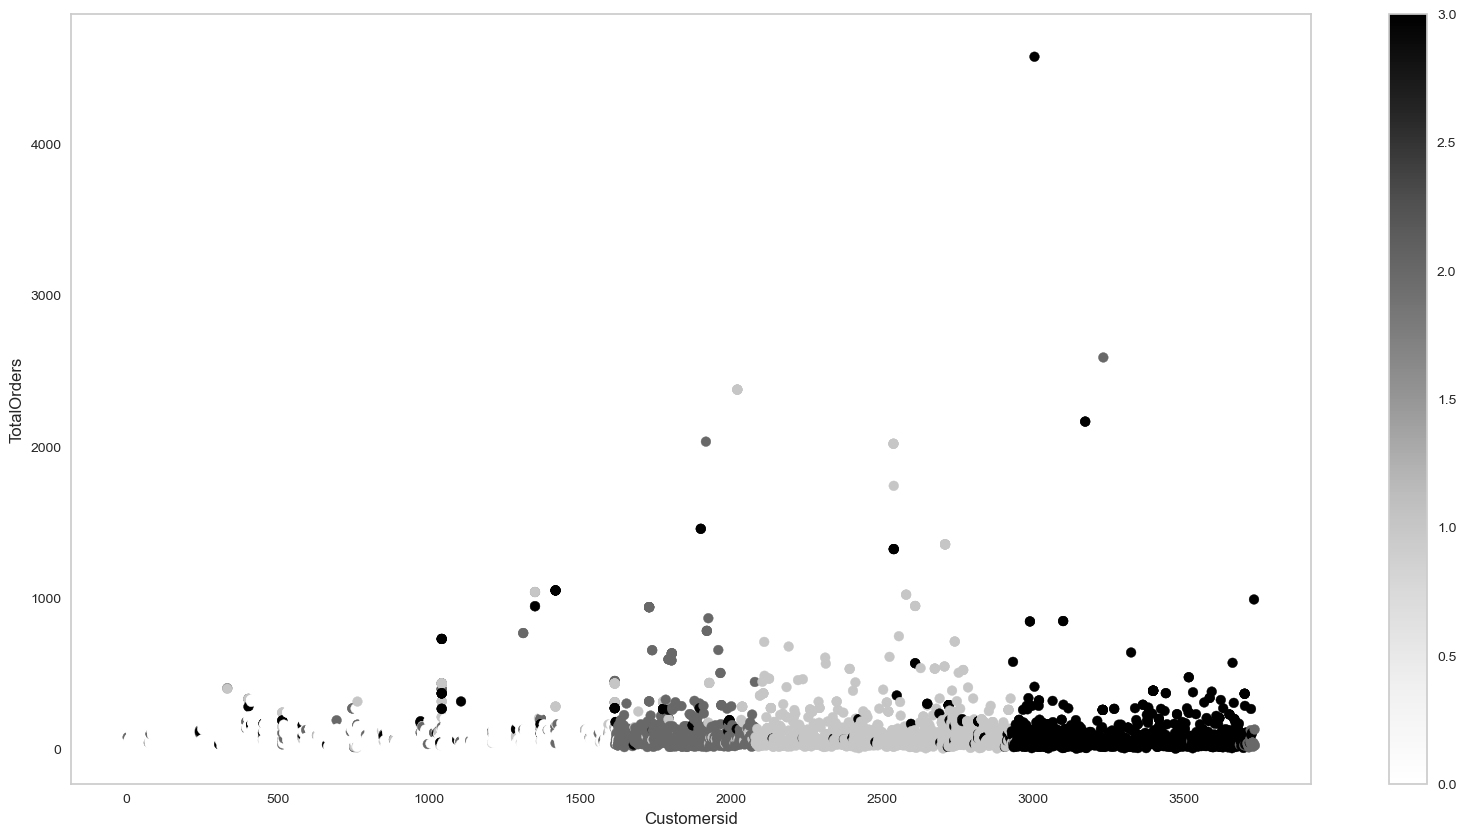

In [38]:
plt.figure(figsize=(20,10))
plt.scatter(y=x["Orders.total"],x=x["Customers.id"],c=tahmin)
plt.xlabel("Customersid")
plt.ylabel("TotalOrders")
plt.colorbar()
plt.grid()

In [29]:
allscore=[]
allcluster=[]
distances=[]
def clust(kactane):
    for i in range(1,kactane):
        i=i+1
        model=KMeans(i)
        model=model.fit(x)
        tahmin=model.predict(x)
        score=silhouette_score(x,tahmin)
        distance=model.inertia_
        print('Cluster ',i," score: ", score)
        allscore.append(score)
        allcluster.append(i)
        distances.append(distance)

In [30]:
 clust(10) 

Cluster  2  score:  0.7642253570116279
Cluster  3  score:  0.6955072493480858
Cluster  4  score:  0.7315723412959872
Cluster  5  score:  0.7067149733311455
Cluster  6  score:  0.7250448405018425
Cluster  7  score:  0.7401918530355105
Cluster  8  score:  0.7643116360685368
Cluster  9  score:  0.7730749837119172
Cluster  10  score:  0.7900181027045099


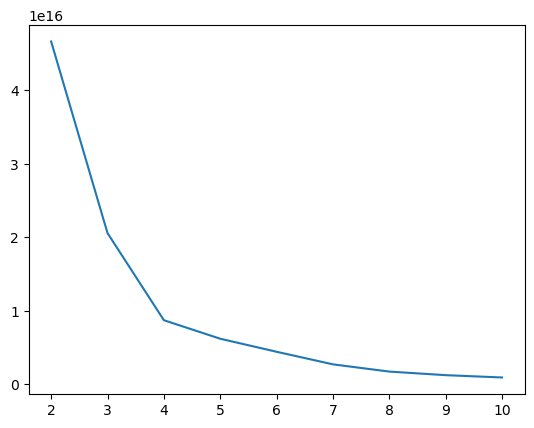

In [31]:
plt.plot(allcluster,distances);
#Elbow Dirsek metodu

In [ ]:
#Kümelenecek dirsek metodu

In [32]:
from yellowbrick.cluster import KElbowVisualizer

In [33]:
model=KMeans()

In [34]:
visualizer=KElbowVisualizer(model,k=(2,10))

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(2, 10))

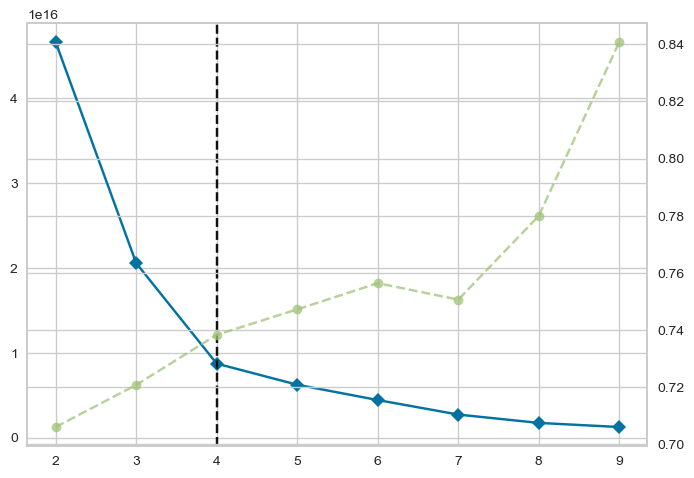

In [35]:
visualizer.fit(x)

In [36]:
visualizer.show()

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
#pip install mlflow

     --------------------------------------- 17.7/17.7 MB 10.2 MB/s eta 0:00:00
     -------------------------------------- 224.5/224.5 kB 4.6 MB/s eta 0:00:00
     -------------------------------------- 148.1/148.1 kB 8.6 MB/s eta 0:00:00
     ---------------------------------------- 184.3/184.3 kB ? eta 0:00:00
     ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
     ---------------------------------------- 41.2/41.2 kB ? eta 0:00:00
     ---------------------------------------- 83.5/83.5 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 20.6/20.6 MB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB 3.5 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143885 sha256=d8c3a292f127515ff1222

In [42]:
#PYCARET
import pycaret
from pycaret.clustering import *
clus1=setup(df2,session_id=123,log_experiment=True,log_plots=True,
           experiment_name="Customer_Clustering")

ImportError: MlflowLogger requires mlflow. Install using `pip install mlflow`

In [43]:
from pycaret.clustering import*

In [45]:
setup(df2)

,Description,Value
0,Session id,7129
1,Original data shape,"(4194, 74)"
2,Transformed data shape,"(4194, 74)"
3,Numeric features,74
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False
